<a href="https://colab.research.google.com/github/liuyuue/BioRNN_WCST/blob/main/CCN_2024_Tutorial_Sparse_Autoencoders_for_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to sparse autoencoders for interpretability

*Most of the content in this tutorial is taken or adapted from [Callum McDougall's tutorial on SAEs and superposition](https://colab.research.google.com/drive/15S4ISFVMQtfc0FPi29HRaX03dWxL65zx#scrollTo=bZ8uXi56vw-r).*

*For questions about this tutorial, contact Jack Lindsey (jackwlindsey@gmail.com). The tutorial was developed with assistance from Ankit Vishnubhotla, Mitchell Ostrow, Minni Sun, and Matteo Alleman.*

https://tinyurl.com/interpCCN

Sparse autoencoders (SAEs) are a tool for decomposing neural network model activations into more interpretable components. SAEs are an instance of a family of “sparse dictionary learning” algorithms that seek to express data as a weighted linear sum of sparsely active components.

Sparse dictionary learning-based approaches to interpreting neural networks are based on two assumptions: (1) the linear representation hypothesis, the claim that neural networks represent meaningful concepts ("features") as linear directions in their activation spaces, and (2) the superposition hypothesis, the claim that ground-truth feature are only sparsely "active" (i.e. only relevant a small fraction of the time), and thus a large number of features can be encoded with minimal interference in a much smaller neural network representation. While neither of these assumptions has been conclusively established, they have proven quite useful.

<div>
<img src="https://drive.google.com/uc?export=view&id=17cSY4_kJ8JXf7NKvtktRXb-T9DG6tEEC" width="200"/>
</div>

(Image from [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html), depicting five features embedded in two-dimensional space.  If the features are sparsely active -- e.g. if only one has a nonzero value at any given time -- then it is easy to decode their values from the 2D projection.)



In particular, in the past year, a variety of groups have shown that SAEs are capable of decomposing model activity into semantically meaningful components that shed light on how model's represent concepts and compute outputs. A standard SAE consists of two layers. The first layer (“encoder”) maps the activity to a higher-dimensional layer via a learned linear transformation followed by a ReLU nonlinearity. We refer to the units of this high-dimensional layer as “SAE features.” The second layer (“decoder”) attempts to reconstruct the model activations via a linear transformation of the feature activations. In the standard SAE formulation model is trained to minimize a combination of (1) reconstruction error and (2) an L1 regularization penalty on the feature activations, which incentivizes sparsity.

Note that recent work suggests that different objective functions and/or architectures can improve SAE performance, but in this tutorial we will focus on the basic setup!

## Setup (don't read, just run!)


In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install packages
    %pip install transformer_lens

    # Code to make matplotlib figures work (particularly animations)
    from matplotlib import rc
    rc('animation', html='jshtml')
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")
    %matplotlib qt

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from IPython.display import display, HTML

device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == "__main__"

In [3]:
#Code in this cell is taken from https://codeload.github.com/callummcdougall/sae-exercises-mats/zip/refs/heads/main

import torch as t
from typing import List, Union
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import re
from transformer_lens.utils import to_numpy
from typing import List

import torch as t
from torch import Tensor
from copy import copy
from IPython.display import clear_output
from typing import List, Union, Optional
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from typing import Tuple, List
from jaxtyping import Float
import einops
from IPython import get_ipython

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider # , Button
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap

Arr = np.ndarray


# GENERIC PLOTTING FUNCTIONS

update_layout_set = {"xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor", "showlegend", "xaxis_tickmode", "yaxis_tickmode", "margin", "xaxis_visible", "yaxis_visible", "bargap", "bargroupgap", "coloraxis_showscale", "xaxis_tickangle", "yaxis2_range"}

def imshow(tensor: t.Tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    facet_labels = kwargs_pre.pop("facet_labels", None)
    border = kwargs_pre.pop("border", False)
    return_fig = kwargs_pre.pop("return_fig", False)
    text = kwargs_pre.pop("text", None)
    xaxis_tickangle = kwargs_post.pop("xaxis_tickangle", None)
    static = kwargs_pre.pop("static", False)
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    if "color_continuous_midpoint" not in kwargs_pre:
        kwargs_pre["color_continuous_midpoint"] = 0.0
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.imshow(to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        # Weird thing where facet col wrap means labels are in wrong order
        if "facet_col_wrap" in kwargs_pre:
            facet_labels = reorder_list_in_plotly_way(facet_labels, kwargs_pre["facet_col_wrap"])
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label
    if border:
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    if text:
        if tensor.ndim == 2:
            # if 2D, then we assume text is a list of lists of strings
            assert isinstance(text[0], list)
            assert isinstance(text[0][0], str)
            text = [text]
        else:
            # if 3D, then text is either repeated for each facet, or different
            assert isinstance(text[0], list)
            if isinstance(text[0][0], str):
                text = [text for _ in range(len(fig.data))]
        for i, _text in enumerate(text):
            fig.data[i].update(
                text=_text,
                texttemplate="%{text}",
                textfont={"size": 12}
            )
    # Very hacky way of fixing the fact that updating layout with new tickangle only applies to first facet by default
    if xaxis_tickangle is not None:
        n_facets = 1 if tensor.ndim == 2 else tensor.shape[0]
        for i in range(1, 1+n_facets):
            xaxis_name = "xaxis" if i == 1 else f"xaxis{i}"
            fig.layout[xaxis_name]["tickangle"] = xaxis_tickangle
    return fig if return_fig else fig.show(renderer=renderer, cfg={"staticPlot": static})


def reorder_list_in_plotly_way(L: list, col_wrap: int):
    '''
    Helper function, because Plotly orders figures in an annoying way when there's column wrap.
    '''
    L_new = []
    while len(L) > 0:
        L_new.extend(L[-col_wrap:])
        L = L[:-col_wrap]
    return L_new


def line(y: Union[t.Tensor, List[t.Tensor]], renderer=None, **kwargs):
    '''
    Edit to this helper function, allowing it to take args in update_layout (e.g. yaxis_range).
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    return_fig = kwargs_pre.pop("return_fig", False)
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    if "xaxis_tickvals" in kwargs_pre:
        tickvals = kwargs_pre.pop("xaxis_tickvals")
        kwargs_post["xaxis"] = dict(
            tickmode = "array",
            tickvals = kwargs_pre.get("x", np.arange(len(tickvals))),
            ticktext = tickvals
        )
    if "hovermode" not in kwargs_post:
        kwargs_post["hovermode"] = "x unified"
    if "use_secondary_yaxis" in kwargs_pre and kwargs_pre["use_secondary_yaxis"]:
        del kwargs_pre["use_secondary_yaxis"]
        if "labels" in kwargs_pre:
            labels: dict = kwargs_pre.pop("labels")
            kwargs_post["yaxis_title_text"] = labels.get("y1", None)
            kwargs_post["yaxis2_title_text"] = labels.get("y2", None)
            kwargs_post["xaxis_title_text"] = labels.get("x", None)
        for k in ["title", "template", "width", "height"]:
            if k in kwargs_pre:
                kwargs_post[k] = kwargs_pre.pop(k)
        fig = make_subplots(specs=[[{"secondary_y": True}]]).update_layout(**kwargs_post)
        y0 = to_numpy(y[0])
        y1 = to_numpy(y[1])
        x0, x1 = kwargs_pre.pop("x", [np.arange(len(y0)), np.arange(len(y1))])
        name0, name1 = kwargs_pre.pop("names", ["yaxis1", "yaxis2"])
        fig.add_trace(go.Scatter(y=y0, x=x0, name=name0), secondary_y=False)
        fig.add_trace(go.Scatter(y=y1, x=x1, name=name1), secondary_y=True)
    else:
        y = list(map(to_numpy, y)) if isinstance(y, list) and not (isinstance(y[0], int) or isinstance(y[0], float)) else to_numpy(y)
        names = kwargs_pre.pop("names", None)
        fig = px.line(y=y, **kwargs_pre).update_layout(**kwargs_post)
        if names is not None:
            fig.for_each_trace(lambda trace: trace.update(name=names.pop(0)))
    return fig if return_fig else fig.show(renderer=renderer)


def scatter(x, y, renderer=None, **kwargs):
    x = to_numpy(x)
    y = to_numpy(y)
    add_line = None
    if "add_line" in kwargs:
        add_line = kwargs.pop("add_line")
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    return_fig = kwargs_pre.pop("return_fig", False)
    facet_labels = kwargs_pre.pop("facet_labels", None)
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.scatter(y=y, x=x, **kwargs_pre).update_layout(**kwargs_post)
    if add_line is not None:
        xrange = fig.layout.xaxis.range or [x.min(), x.max()]
        yrange = fig.layout.yaxis.range or [y.min(), y.max()]
        add_line = add_line.replace(" ", "")
        if add_line in ["x=y", "y=x"]:
            fig.add_trace(go.Scatter(mode='lines', x=xrange, y=xrange, showlegend=False))
        elif re.match("(x|y)=", add_line):
            try: c = float(add_line.split("=")[1])
            except: raise ValueError(f"Unrecognized add_line: {add_line}. Please use either 'x=y' or 'x=c' or 'y=c' for some float c.")
            x, y = ([c, c], yrange) if add_line[0] == "x" else (xrange, [c, c])
            fig.add_trace(go.Scatter(mode='lines', x=x, y=y, showlegend=False))
        else:
            raise ValueError(f"Unrecognized add_line: {add_line}. Please use either 'x=y' or 'x=c' or 'y=c' for some float c.")
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label
    return fig if return_fig else fig.show(renderer=renderer)


def bar(tensor, renderer=None, **kwargs):
    '''
    '''
    if isinstance(tensor, list):
        if isinstance(tensor[0], t.Tensor): arr = [to_numpy(tn) for tn in tensor]
        elif isinstance(tensor[0], list): arr = [np.array(tn) for tn in tensor]
        else: arr = np.array(tensor)
    else:
        arr = to_numpy(tensor)
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    return_fig = kwargs_pre.pop("return_fig", False)
    names = kwargs_pre.pop("names", None)
    if "hovermode" not in kwargs_post:
        kwargs_post["hovermode"] = "x unified"
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    fig = px.bar(y=arr, **kwargs_pre).update_layout(**kwargs_post)
    if names is not None:
        for i in range(len(fig.data)):
            fig.data[i]["name"] = names[i // 2 if "marginal" in kwargs_pre else i]
    return fig if return_fig else fig.show(renderer=renderer)


def hist(tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    draw = kwargs_pre.pop("draw", True)
    static = kwargs_pre.pop("static", False)
    return_fig = kwargs_pre.pop("return_fig", False)
    if isinstance(tensor, list):
        if isinstance(tensor[0], t.Tensor): arr = [to_numpy(tn) for tn in tensor]
        elif isinstance(tensor[0], list): arr = [np.array(tn) for tn in tensor]
        else: arr = np.array(tensor)
    else:
        arr = to_numpy(tensor)
    if "modebar_add" not in kwargs_post:
        kwargs_post["modebar_add"] = ['drawline', 'drawopenpath', 'drawclosedpath', 'drawcircle', 'drawrect', 'eraseshape']
    add_mean_line = kwargs_pre.pop("add_mean_line", False)
    names = kwargs_pre.pop("names", None)
    if "barmode" not in kwargs_post:
        kwargs_post["barmode"] = "overlay"
    if "bargap" not in kwargs_post:
        kwargs_post["bargap"] = 0.0
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    if "hovermode" not in kwargs_post:
        kwargs_post["hovermode"] = "x unified"
    if "autosize" not in kwargs_post:
        kwargs_post["autosize"] = False

    # If `arr` has a list of arrays, then just doing px.histogram doesn't work annoyingly enough
    # This is janky, even for my functions!
    if isinstance(arr, list) and isinstance(arr[0], np.ndarray):
        assert "marginal" not in kwargs_pre, "Can't use `marginal` with a list of arrays"
        for thing_to_move_from_pre_to_post in ["title", "template", "height", "width", "labels"]:
            if thing_to_move_from_pre_to_post in kwargs_pre:
                kwargs_post[thing_to_move_from_pre_to_post] = kwargs_pre.pop(thing_to_move_from_pre_to_post)
        if "labels" in kwargs_post:
            kwargs_post["xaxis_title_text"] = kwargs_post["labels"].get("x", "")
            kwargs_post["yaxis_title_text"] = kwargs_post["labels"].get("y", "")
            del kwargs_post["labels"]
        fig = go.Figure(layout=go.Layout(**kwargs_post))
        if "nbins" in kwargs_pre:
            kwargs_pre["nbinsx"] = int(kwargs_pre.pop("nbins"))
        for x in arr:
            fig.add_trace(go.Histogram(x=x, name=names.pop(0) if names is not None else None, **kwargs_pre))
    else:
        fig = px.histogram(x=arr, **kwargs_pre).update_layout(**kwargs_post)
        if names is not None:
            for i in range(len(fig.data)):
                fig.data[i]["name"] = names[i // 2 if "marginal" in kwargs_pre else i]

    if add_mean_line:
        if arr.ndim == 1:
            fig.add_vline(x=arr.mean(), line_width=3, line_dash="dash", line_color="black", annotation_text=f"Mean = {arr.mean():.3f}", annotation_position="top")
        elif arr.ndim == 2:
            for i in range(arr.shape[0]):
                fig.add_vline(x=arr[i].mean(), line_width=3, line_dash="dash", line_color="black", annotation_text=f"Mean = {arr.mean():.3f}", annotation_position="top")
    return fig if return_fig else fig.show(renderer=renderer)

# (1) Training sparse autoencoders on a toy model with known ground-truth features (25 minutes)

### Problem setup

To begin, we will consider a toy model of neural network activations which we can use to experiment with sparse autoencoders. Our toy model embeds a set of 5 ground-truth "features" (sparsely active, uncorrelated variables whose activity is denoted with a five-dimensional vector x) into a lower-dimensional (2D) space (hidden activations h), in such a way that they can be reconstructed accurately (x' is the attempted reconstruction) with a single-layer decoder.  

$$
\begin{aligned}
h &= W x \\
x' &= \operatorname{ReLU}(W^T h + b)
\end{aligned}
$$


In other words our toy model is itself the opposite of a sparse autoencoder! It attempts to near-losslessly compress high-dimensional information (in this case five uncorrelated variables) into a lower-dimensional space -- a kind of representation we call *superposition*. This is meant to (very roughly!) model what we believe is going on in large deep learning models like LLMs, which manage to represent, and compute with, a large variety of concepts despite possessing a relatively small number of neurons.

The job of our sparse autoencoder will be to *reverse* this compression process -- extracting the latent sparse and high-dimensional (5D in this example) features from the dense, low-dimensional (2D in this example) model activations.

### Toy Model setup code (no need to read)

In [4]:
def constant_lr(*_):
    return 1.0

# This is a config class we use to simplify passing in the parameters mentioned above.
@dataclass
class Config:
    # We optimize n_instances models in parallel in a single training loop to let us sweep over
    # sparsity or other hyperparameters efficiently. You should treat `n_instances` as
    # kinda like a batch dimension, but one which is built into our training setup.
    n_instances: int
    n_features_gt: int = 5
    n_hidden: int = 2

class Model(nn.Module):
    # We use the typing package to specify the shapes of the Model matrices, as
    # well as the shapes of the function inputs.
    W: Float[Tensor, "n_instances n_hidden n_features_gt"]
    b_final: Float[Tensor, "n_instances n_features_gt"]
    # Our linear map is x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]],
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        # feature probability denotes the "sparsity" of each of the ground-truth
        # features, or the probability that the feature is nonzero
        feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features_gt))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features_gt))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features_gt)))
        # self.device = device
        self.to(device)


    # Fill in the input & output parameters/shapes to the matrix multiplications
    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        # Use Einstein Notation to perform matrix multiplications
        # by specifying input and output shapes of the operation
        hidden = einops.einsum(
           features, self.W,
           "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        return F.relu(out + self.b_final)


    # Fill in the input & output parameters/shapes to the data generation
    def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data. We'll return to this function later when we apply correlations.
        '''
        # Generate the features, before randomly setting some to zero
        feat = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features_gt), device=self.W.device)

        # Generate a random boolean array, which is 1 wherever we'll keep a feature, and zero where we'll set it to zero
        feat_seeds = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features_gt), device=self.W.device)
        feat_is_present = feat_seeds <= self.feature_probability

        # Create our batch from the features, where we set some to zero
        batch = t.where(feat_is_present, feat, 0.0)

        return batch


    # Fill in the input & output parameters/shapes to calculating the loss
    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:
        '''
        Calculates the loss for a given batch, using this loss described in the Toy Models paper:
        '''
        error = (batch - out) ** 2
        loss = einops.reduce(error, 'batch instances features -> instances', 'mean').sum()
        return loss


    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        '''
        Optimizes the model using the given hyperparameters.
        '''
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)

## Toy Model Activations

First, we'll optimize our toy model to compress sparsely active features, and generate an example batch of model activations.

In [5]:
cfg = Config(
    n_instances = 8, # we'll work with multiple toy models in parallel to check the robustness/consistency of our results
    n_features_gt = 5, # 5 ground truth features
    n_hidden = 2, # 2 dimensions in the toy model activations
)
model = Model(
    cfg = cfg,
    device = device,
    feature_probability = 0.01, # sparsity of the ground-truth "features" that generate the toy model activations
)
model.optimize(steps=10_000)

batch_size = 1000
feature_values = model.generate_batch(batch_size) #shape is [batch_size, n_instances, n_features_gt]
activations = einops.einsum(feature_values, model.W, "batch_size instances features, instances hidden features -> instances hidden batch_size")

  0%|          | 0/10000 [00:00<?, ?it/s]

Now we'll look at the axes along which the model has chosen to embed the features in the activation space.  The feature activations are one-hot vectors, so the embedding directions are simply the model's embedding weights (`model.W`). There are 5 features and 2 dimensions, so we can plot these as five vectors (black lines with circles at the end).

We can also visualize our batch of example activations (blue x's). In this example, our features are so sparse that usually at most one feature is active at a time, and so the activations are aligned with a single feature direction. Sometimes more than one feature is active, resulting in activations that are linear combinations of multiple feature directions.

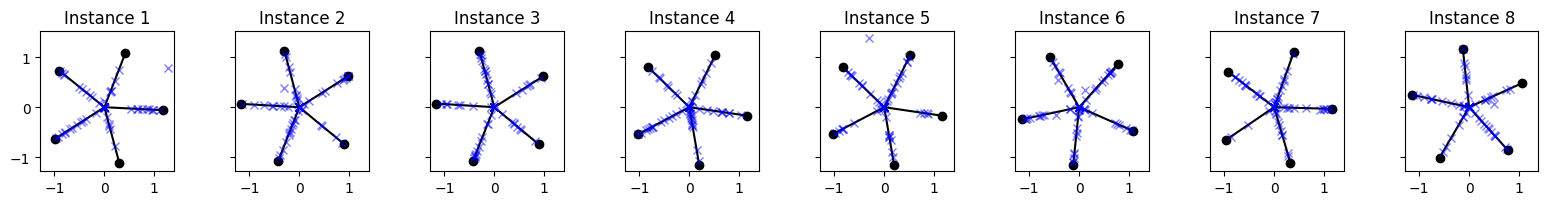

In [6]:

def plot_features_in_2d(W, activations=None):
  fig, axs = plt.subplots(1, cfg.n_instances, figsize=(2*cfg.n_instances, 2), sharex=True, sharey=True)

  for i in range(cfg.n_instances):
      ax = axs[i]
      ax.set_aspect('equal')
      ax.set_xticks([-1, 0, 1])
      ax.set_yticks([-1, 0, 1])

      # Plot feature directions
      for j in range(cfg.n_features_gt):
          x, y = W[i, :, j].detach().cpu()
          ax.plot([0, x], [0, y], 'k-')  # Line from origin to point
          ax.plot(x, y, 'o', color='k')  # Arrow marker

      if activations is not None:
        #Plot example activations
        for d in range(batch_size):
          x, y = activations[i, :, d].detach().cpu()
          ax.plot(x, y, color="blue", marker="x", alpha=0.5)

      ax.set_title(f'Instance {i+1}', fontsize=12)


  plt.tight_layout()
  plt.show()

plot_features_in_2d(model.W, activations=activations)

### Autoencoder setup


We're going to train a sparse autoencoder to try to infer the underlying features -- their activity values and their embedding directions -- from the model activations alone.  We'll take in the hidden state activations $h$, map them to a larger ("overcomplete") hidden state $z$, then reconstruct the original hidden state $h$ from $z$.

$$
\begin{aligned}
z &= \operatorname{ReLU}(W_{enc}(h - b_{dec}) + b_{enc}) \\
h' &= W_{dec}z + b_{dec}
\end{aligned}
$$

### Notation

We call the hidden activations of the autoencoder **autoencoder features**.

Notation:

- `n_features_gt` = number of ground-truth features in the data generating process.
- `n_hidden` = number of hidden dimensions of the underlying model.
- `n_input_ae` = number of input dimensions for the **autoencoder**.
- `n_hidden_ae` = number of hidden dimensions / neurons / features of your **autoencoder**. We require `n_hidden_ae >= n_features_gt` for our autoencoder to have a chance of reconstructing all the features. Usually we'll have `n_hidden_ae == n_features_gt` in this section.

<details>
<summary>Question - in the formulas above, what are the shapes of x, x', z, h, and h' ?</summary>

Ignoring batch and instance dimensions:

- `x` and `x'` are vectors of shape `(n_features_gt,)`
- `z` is a vector of shape `(n_hidden_ae,)`, which will usually be equal to or larger than `n_features_gt` (so that our autoencoder is overcomplete)
- `h` and `h'` are vectors of shape `(n_input_ae,)`, also equal to `(n_hidden,)`

Including batch and instance dimensions, all shapes `(d,)` above turn into `(batch_size, n_instances, d)`.

</details>

### Exercise - define your SAE

We've provided an `AEConfig` class below. Its arguments are `n_instances`, `n_input_ae` (which is the size of the toy model's hidden layer, i.e. the things which will be the input into your autoencoder), and `n_hidden_ae` (which is the size of the **AutoEncoder's** hidden layer). In our case, we'll set this to be the same as the ground-truth number of features `n_features_gt` of the toy model (in real applications, you don't know the ground truth number of features!!)

The `AutoEncoder` class contains methods `__init__` and `forward` which are mostly written, but have some blanks to fill in for the key tensor operations. The code you'll need to fill in makes heavy use of the `einsum` function.

If you aren't familiar with einsum (which stands for "Einstein summation notation") -- it is a powerful notation for expressing matrix multiplication-like tensor operations.  As an example, suppose `x` has shape `[batch_size, a, b]`, and `y` has shape `[batch_size, b, c]`, and I want to loop over the `batch_size` dimension and perform a matrix multiplication using the `[a, b]` and `[b, c]` dimensions. With `einsum` I can write this as `einsum(x, y, "batch a b, batch b c -> batch a c")`. You specify the dimensions of the inputs and the desired outputs, and any dimensions that are repeated in the two inputs but don't appear in the output will be summed over (as in matrix multiplication). The strings you use to refer to the dimensions are up to you, so it helps to use descriptive names.

### `__init__`

- You have weight matrices `W_dec` and `W_enc`, as well as biases `b_dec` and `b_enc`. The biases can be initialized at zero, and the weights can be initialized with xavier normal initialization like they were for your model.
    - We've given you the type signatures for these classes, so you know what shape they should be.
    - Remember to move your parameters to the correct device! (You can copy the code from `Model` class earlier.)

### `forward`

- You should calculate the autoencoder's hidden state activations as $z = \operatorname{ReLU}(W_{enc}(h - b_{dec}) + b_{enc})$, and then reconstruct the output as $h' = W_{dec}z + b_{dec}$.

- This function should return the following 5 arguments, in order:
    - `l1_loss`, which is the absolute values of post-ReLU activations $z$, **summed** over the hidden dimension `n_hidden_ae`. This should have shape `(batch_size, n_instances)`.
    - `l2_loss`, which is the reconstruction loss between $h$ and $h'$ (i.e. the squared differences between elements of this vector, **averaged** over the dimensionality of the vectors `n_input_ae`). This should have shape `(batch_size, n_instances)`.
    - `loss`, which is the sum of the $L_1$ and $L_2$ losses (i.e. a scalar).
        - Note, we should sum over the `n_instances` dimension (because each instance should be training at the same rate), but we should take the mean over the `batch_size` dimension.
        - Also, the `l1_loss` should be multiplied by the `config.l1_coeff` parameter before adding the two scalars together.
    - `acts`, which are the hidden state activations $z$. This should have shape `(batch_size, n_instances, n_hidden_ae)`.
    - `h_reconstructed`, which are the reconstructed inputs $h'$. This should have shape `(batch_size, n_instances, n_input_ae)`.

<details>
<summary>Question - why do you think we sum over the hidden dimension when computing <code>l1_loss</code>, but average over the hidden dimension for <code>l2_loss</code> ?</summary>

Suppose we took the average of $L_1$ loss over the `n_hidden_ae` dimension; we'll create a thought experiment to show why this would be bad.

Consider a single feature, in an autoencoder with a fixed `n_input_ae` but a variable number of features `n_hidden_ae`. If we double the number of features, then any change in that feature will affect the $L_2$ loss by the same amount. But the $L_1$ loss would be affected by half that amount, since we're averaging the $L_1$ norm over all features. So the more features we have in our model, the less any given feature will be encouraged to be sparse. In the limit, feature sparsity basically won't matter at all; only reconstruction loss will matter.

On the other hand, if we sum $L_1$ loss over the `n_hidden_ae` dimension, then in this thought experiment, the effect of a change in any given feature is still the same for $L_1$ and $L_2$ loss, so we don't have this problem.

</details>

<br>

Ignore the `resample_neurons` method for now, we'll discuss it later.

In [8]:
@dataclass
class AutoEncoderConfig:
    n_instances: int = 8
    n_input_ae: int = 2
    n_hidden_ae: int = 6
    l1_coeff: float = 0.5


class AutoEncoder(nn.Module):
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    # fill in some of the shapes of the bias vectors based on
    # the equation for calculating z
    def __init__(self, cfg: AutoEncoderConfig):
        super().__init__()
        self.cfg = cfg
        self.W_enc = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
        self.W_dec = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))
        self.b_enc = nn.Parameter(t.zeros(cfg.n_instances, __________))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_instances, __________))
        self.to(device)

    def forward(self, h: Float[Tensor, "batch_size n_instances n_input_ae"]):

        # Compute activations from the
        h_cent = h - self.b_dec
        acts = einops.einsum(
            h_cent, self.W_enc,
            "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
        )
        acts = F.relu(acts + self.b_enc)

        # Compute reconstructed input
        h_reconstructed = einops.einsum(
            __________, __________,
            "batch_size n_instances __________, n_instances __________ __________ -> __________ n_instances __________"
        ) + __________

        # Compute loss, return values
        l2_loss = (h_reconstructed - h).pow(2).mean(-1) # shape [batch_size n_instances]
        l1_loss = acts.abs().sum(-1) # shape [batch_size n_instances]
        loss = (__________ * __________ + __________).mean(__________).sum() # scalar

        return l1_loss, l2_loss, loss, acts, h_reconstructed

    @t.no_grad()
    def normalize_decoder(self) -> None:
        '''
        Normalizes the decoder weights to have unit norm.
        '''
        self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)

    @t.no_grad()
    def resample_neurons(
        self,
        h: Float[Tensor, "batch_size n_instances n_hidden"],
        frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
        neuron_resample_scale: float,
    ) -> None:
        '''
        Resamples neurons that have been dead for `dead_neuron_window` steps, according to `frac_active`.
        '''
        pass

    def optimize(
        self,
        model: Model,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        neuron_resample_window: Optional[int] = None,
        dead_neuron_window: Optional[int] = None,
        neuron_resample_scale: float = 0.2,
    ):
        '''
        Optimizes the autoencoder using the given hyperparameters.

        This function should take a trained model as input.
        '''
        if neuron_resample_window is not None:
            assert (dead_neuron_window is not None) and (dead_neuron_window < neuron_resample_window)

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"W_enc": [], "W_dec": [], "colors": [], "titles": [], "frac_active": []}
        colors = None
        title = "no resampling yet"

        for step in progress_bar:

            # Normalize the decoder weights before each optimization step
            self.normalize_decoder()

            # Resample dead neurons
            if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
                # Get the fraction of neurons active in the previous window
                frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
                # Compute batch of hidden activations which we'll use in resampling
                batch = model.generate_batch(batch_size)
                h = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
                # Resample
                colors, title = self.resample_neurons(h, frac_active_in_window, neuron_resample_scale)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                features = model.generate_batch(batch_size)
                h = einops.einsum(features, model.W, "... instances features, instances hidden features -> ... instances hidden")

            # Optimize
            optimizer.zero_grad()
            l1_loss, l2_loss, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()

            # Calculate the sparsities, and add it to a list
            frac_active = einops.reduce((acts.abs() > 1e-8).float(), "batch_size instances hidden_ae -> instances hidden_ae", "mean")
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(l1_loss=self.cfg.l1_coeff * l1_loss.mean(0).sum().item(), l2_loss=l2_loss.mean(0).sum().item(), lr=step_lr)
                data_log["W_enc"].append(self.W_enc.detach().cpu())
                data_log["W_dec"].append(self.W_dec.detach().cpu())
                data_log["colors"].append(colors)
                data_log["titles"].append(f"Step {step}/{steps}: {title}")
                data_log["frac_active"].append(frac_active.detach().cpu())

        return data_log

####Solution

In [10]:
@dataclass
class AutoEncoderConfig:
    n_instances: int
    n_input_ae: int
    n_hidden_ae: int
    l1_coeff: float = 0.5


class AutoEncoder(nn.Module):
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    # fill in some of the shapes of the bias vectors based on
    # the equation for calculating z
    def __init__(self, cfg: AutoEncoderConfig):
        super().__init__()
        self.cfg = cfg
        self.W_enc = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
        self.W_dec = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))
        self.b_enc = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_input_ae))
        self.to(device)

    def forward(self, h: Float[Tensor, "batch_size n_instances n_hidden"]):

        # Compute activations
        h_cent = h - self.b_dec
        acts = einops.einsum(
            h_cent, self.W_enc,
            "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
        )
        acts = F.relu(acts + self.b_enc)

        # Compute reconstructed input
        h_reconstructed = einops.einsum(
            acts, self.W_dec,
            "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae"
        ) + self.b_dec

        # Compute loss, return values
        l2_loss = (h_reconstructed - h).pow(2).mean(-1) # shape [batch_size n_instances]
        l1_loss = acts.abs().sum(-1) # shape [batch_size n_instances]
        loss = (self.cfg.l1_coeff * l1_loss + l2_loss).mean(0).sum() # scalar

        return l1_loss, l2_loss, loss, acts, h_reconstructed

    @t.no_grad()
    def normalize_decoder(self) -> None:
        '''
        Normalizes the decoder weights to have unit norm.
        '''
        self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)

    @t.no_grad()
    def resample_neurons(
        self,
        h: Float[Tensor, "batch_size n_instances n_hidden"],
        frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
        neuron_resample_scale: float,
    ) -> None:
        '''
        Resamples neurons that have been dead for `dead_neuron_window` steps, according to `frac_active`.
        '''
        pass # See below for a solution to this function

    def optimize(
        self,
        model: Model,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        neuron_resample_window: Optional[int] = None,
        dead_neuron_window: Optional[int] = None,
        neuron_resample_scale: float = 0.2,
    ):
        '''
        Optimizes the autoencoder using the given hyperparameters.

        This function should take a trained model as input.
        '''
        if neuron_resample_window is not None:
            assert (dead_neuron_window is not None) and (dead_neuron_window < neuron_resample_window)

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"W_enc": [], "W_dec": [], "colors": [], "titles": [], "frac_active": []}
        colors = None
        title = "no resampling yet"

        for step in progress_bar:

            # Normalize the decoder weights before each optimization step
            self.normalize_decoder()

            # Resample dead neurons
            if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
                # Get the fraction of neurons active in the previous window
                frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
                # Compute batch of hidden activations which we'll use in resampling
                batch = model.generate_batch(batch_size)
                h = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
                # Resample
                colors, title = self.resample_neurons(h, frac_active_in_window, neuron_resample_scale)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                features = model.generate_batch(batch_size)
                h = einops.einsum(features, model.W, "... instances features, instances hidden features -> ... instances hidden")

            # Optimize
            optimizer.zero_grad()
            l1_loss, l2_loss, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()

            # Calculate the sparsities, and add it to a list
            frac_active = einops.reduce((acts.abs() > 1e-8).float(), "batch_size instances hidden_ae -> instances hidden_ae", "mean")
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(l1_loss=self.cfg.l1_coeff * l1_loss.mean(0).sum().item(), l2_loss=l2_loss.mean(0).sum().item(), lr=step_lr)
                data_log["W_enc"].append(self.W_enc.detach().cpu())
                data_log["W_dec"].append(self.W_dec.detach().cpu())
                data_log["colors"].append(colors)
                data_log["titles"].append(f"Step {step}/{steps}: {title}")
                data_log["frac_active"].append(frac_active.detach().cpu())

        return data_log

### Training our autoencoder

The `optimize` method is given to you. Some important notes:

- We're training our autoencoder on the hidden state activations $h$ of our model, rather than from the original randomly generated ground-truth features $x$. We don't generate data directly from the `Model.generate_batch` method, but rather we use this method to generate features then use those features to generate hidden state activations for our model, which we use as the input to our autoencoder.
- Our autoencoder loss is the sum of the $L_1$ and $L_2$ losses returned by the `forward` function.
- The `optimize` method logs some more interesting data, including the fraction of hidden state activations $h$ which are active, for each instance. It also returns these values as a tensor at the end.

Verify we get the pentagon pattern we expect, for all instances:

Generate a random batch, and verify that the embeddings more or less line up with what we expect:

Next, we train our autoencoder. The `optimize` function is set up to return a dictionary `data_log` containing data which is useful for visualizing the training process. We'll use this to create an animation of the autoencoder training over time.

In [11]:
ae_cfg = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    l1_coeff = 0.5,
)
autoencoder = AutoEncoder(ae_cfg)

data_log = autoencoder.optimize(
    model = model,
    steps = 10_000,
    log_freq = 1000,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Now we'll plot the feature directions inferred by the model (adjust the slider to see them evolve over the course of training!).  Specifically, we'll plot the encoder and decoder weights of the model (a question to think about -- would you expect the encoder weights or the decoder weights to better correspond to ground-truth feature directions?)

A question to think about -- why do the decoder weights of the model correspond to its inferred feature embedding directions?  Would the encoder weights work just as well?

We'll also plot some reconstructions generated by the model, in blue x's.

ENCODER


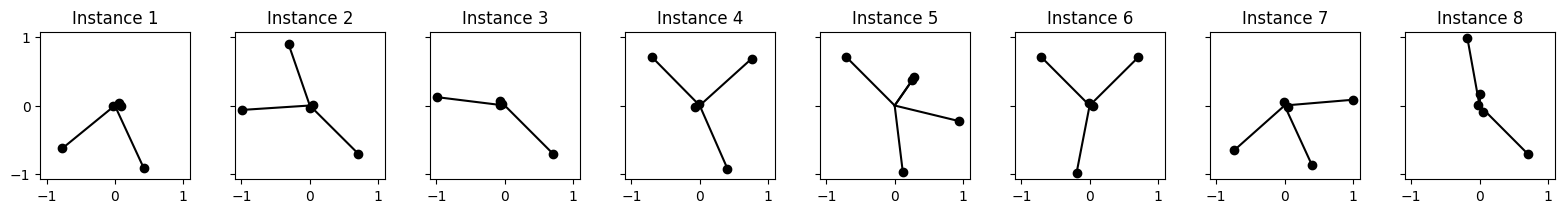

DECODER


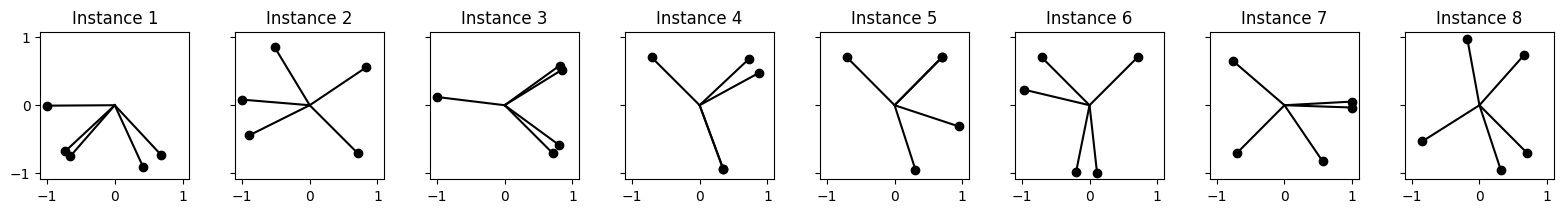

In [12]:
print("ENCODER")
plot_features_in_2d(
    data_log["W_enc"][-1],
)

print("DECODER")
plot_features_in_2d(
    data_log["W_dec"][-1].transpose(-1, -2),
)

That doesn't look good!  Many of autoencoder's encoder weights are zero! And the decoder weights corresponding to the zero-encoder features are pointing in essentially random directions.

Let's dig into this further by graphing the feature sparsity levels over training. You should find that there are 2 types of features: ones which converge roughly to the expected feature probability of $0.01$, and ones which quickly converge to zero. These latter neurons are **"dead autoencoder features"**, and they're an annoying problem when training sparse autoencoders.

In [14]:
def frac_active_line_plot(
    frac_active,
    feature_probability,
):
    n_steps, n_instances, n_hidden_ae = frac_active.shape

    y_max = feature_probability * 3

    fig = go.Figure(layout=dict(
        template = "simple_white",
        title = "Probability of autoencoder neurons being active during training",
        xaxis_title = "Training Step",
        yaxis_title = "Fraction of Active Neurons",
        yaxis_range = [0, y_max],
        width=1000
    ))

    for inst in range(n_instances):
        for neuron in range(n_hidden_ae):
            fig.add_trace(go.Scatter(
                x = list(range(0, n_steps)),
                y = frac_active[:, inst, neuron].tolist(),
                name = f"AE neuron #{neuron}",
                mode = "lines",
                opacity = 0.3,
                legendgroup = f"Instance #{inst}",
                legendgrouptitle_text = f"Instance #{inst}",
            ))
    fig.add_hline(
        y = feature_probability,
        opacity = 1,
        line = dict(color="black", width=2),
        annotation_text = "Feature prob",
        annotation_position = "bottom left",
        annotation_font_size = 14,
    )
    fig.show()


frac_active_line_plot(
    frac_active = t.stack(data_log["frac_active"], dim=0),
    feature_probability = 0.01,
)

### Addressing dead features

These "dead" neurons are a common problem when training SAEs. Fundamentally, they arise from the L1 penalty incentivizing neurons to be inactive.  Some recent research suggests that alternative SAE architectures may mitigate this issue by avoiding the L1 penalty altogether and using different ways of encouraging sparsity. There have also been a variety of mitigations proposed in the context of the standard L1-based SAE.

Here we provide an implementation of one of these mitigations, known as "neuron resampling." At a high level, the idea behind resampling is to re-initialize the weights corresponding to dead SAE neurons, so that they have the opportunity  to learn again.  The implementation logic can be finnicky, so we won't ask you to implement this yourself -- just run the cells below.

You'll find that by addressing the dead features issue, the SAE will perform much better.

#### Neuron resampling algorithm (optional to read)

Specifically, we'll implement the following algorithm:

* Find the dead neurons for this instance (i.e. the `neuron` values s.t. `frac_active_in_window[:, instance, neuron]` are all zero).
* For each dead neuron `dead_feature_idx` in this instance, you should:
    * Generate a new random vector `v` of length `n_input_ae`, and normalize it to have unit length.
    * Set the decoder weights `W_dec[inst, dead_feature_idx, :]` to this new vector `v`.
    * Set the encoder weights `W_enc[inst, :, dead_feature_idx]` to this new vector `v`.
    * Set the encoder biases `W_enc[inst, dead_feature_idx]` to zero.

In [16]:

@t.no_grad()
def resample_neurons(
    self: AutoEncoder,
    h: Float[Tensor, "batch_size n_instances n_hidden"],
    frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
    neuron_resample_scale: float,
) -> None:
    '''
    Resamples neurons that have been dead for 'dead_neuron_window' steps, according to `frac_active`.
    '''
    # Get a tensor of dead neurons
    dead_features_mask = frac_active_in_window.sum(0) < 1e-8 # shape [instances hidden_ae]
    n_dead = dead_features_mask.int().sum().item()

    # Get our random replacement values
    replacement_values = t.randn((n_dead, self.cfg.n_input_ae), device=self.W_enc.device) # shape [n_dead n_input_ae]
    replacement_values_normalized = replacement_values / (replacement_values.norm(dim=-1, keepdim=True) + 1e-8)

    # Change the corresponding values in W_enc, W_dec, and b_enc (note we transpose W_enc to return a view with correct shape)
    self.W_enc.data.transpose(-1, -2)[dead_features_mask] = replacement_values_normalized
    self.W_dec.data[dead_features_mask] = replacement_values_normalized
    self.b_enc.data[dead_features_mask] = 0.0

    # Return data for visualising the resampling process
    colors = [["red" if dead else "black" for dead in dead_neuron_mask_inst] for dead_neuron_mask_inst in dead_features_mask]
    title = f"resampling {n_dead}/{dead_features_mask.numel()} neurons (shown in red)"
    return colors, title


AutoEncoder.resample_neurons = resample_neurons

#### SAE training attempt #2

Now we'll try training our SAE again, this time with neuron resampling.

In [17]:
ae_cfg = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    l1_coeff = 0.25,
)
autoencoder = AutoEncoder(ae_cfg)

data_log = autoencoder.optimize(
    model = model,
    steps = 20_000,
    neuron_resample_window = 2_500,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 1000,
)

  0%|          | 0/20000 [00:00<?, ?it/s]

### Post-resampling results

We can see that the problem of dead features has been resolved below:

In [18]:
frac_active_line_plot(
    frac_active = t.stack(data_log["frac_active"], dim=0),
    feature_probability = 0.01,
)

ENCODER


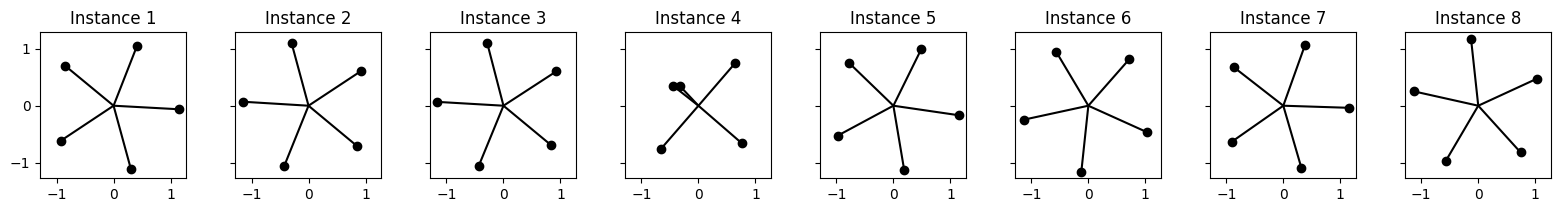

DECODER


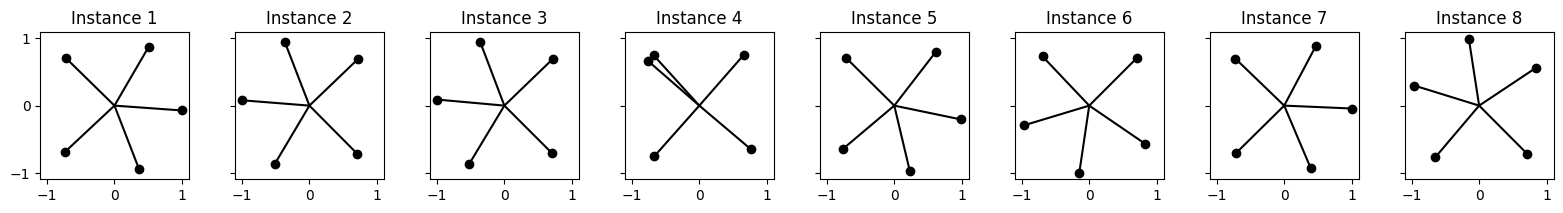

In [19]:
print("ENCODER")
plot_features_in_2d(
    data_log["W_enc"][-1],
)

print("DECODER")
plot_features_in_2d(
    data_log["W_dec"][-1].transpose(-1, -2),
)

Compare the SAE-inferred feature directions above to the ground-truth feature directions below. It's not perfect, but in most instances they match pretty closely!

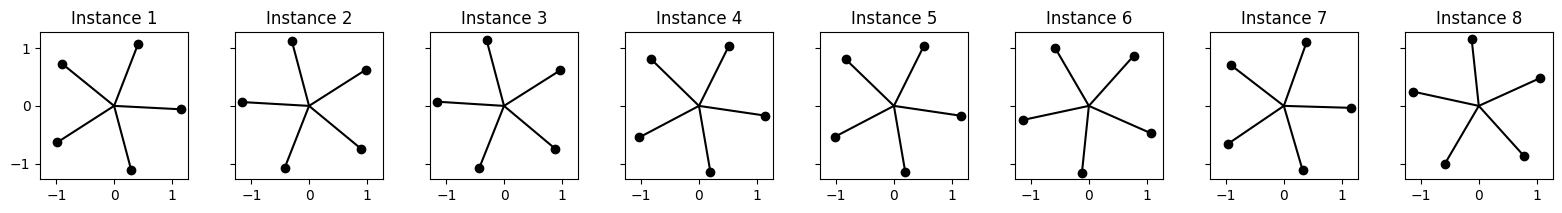

In [20]:
plot_features_in_2d(
    model.W,
)

In conclusion, we've seen that properly implemented sparse autoencoders can accurately infer ground-truth sparse features underlying observed activations.

# (2) Sparse Autoencoders applied to language models (25 minutes)

Now that we've trained SAEs on a toy model, we'll graduate to some more realistic models.

Currently, the open-source infrastructure for training SAEs is very much in development, and we'd love you to help build it out! But for now, we'll take an SAE which was trained on activations of a GELU-1l model (from Neel Nanda's HookedTransformer library). Specifically, these are the MLP neuron activations from a 1-layer transformer.

If you're not familiar with the transformer architecture, no worries -- you actually don't need to be for this exercise!  All you need to know is that these activations are internal model representations of a text sequence.

First, here's some code to load in sparse autoencoders. We'll load in two different SAEs, denoted with the parameter `version`. These have the same architectures & were trained in the same way, but with different random seeds. This is a robustness check -- if two different SAE runs find the same feature, that's evidence that the feature is universal rather than just a fluke of the training process.

We'll load in both of these autoencoders into the same `AutoEncoder` object (as 2 different **instances**).

A few notes / pieces of terminology:

- Because we're working with an MLP layer, we'll use `d_mlp` to denote the size of the MLP layer - this is equivalent to `n_input_ae` or `n_features_gt` in the previous section. We'll keep using `n_hidden_ae` to refer to the autoencoder's hidden dimension.
- The **dictionary multiplier** (denoted `dict_mult` below) is the factor by which the autoencoder's hidden dimension is larger than the model's hidden dimension, in other words `n_hidden_ae = dict_mult * d_mlp`.
- We're  now working with a real language model rather than a toy data-generating process with known ground-truth features, so when we say "features" in this section we're referring to the autoencoder's hidden values rather than theoretical "true features" of the data-generation process.

### Imports and setup

In [22]:
from transformer_lens import HookedTransformer, FactoredMatrix
from transformer_lens.hook_points import HookPoint

from transformer_lens.utils import (
    load_dataset,
    tokenize_and_concatenate,
    download_file_from_hf,
)

In [23]:
VERSION_DICT = {"run1": 25, "run2": 47}

def load_autoencoder_from_huggingface(versions: List[str] = ["run1", "run2"]):
    state_dict = {}

    for version in versions:
        version_id = VERSION_DICT[version]
        # Load the data from huggingface (both metadata and state dict)
        sae_data: dict = download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version_id}_cfg.json")
        new_state_dict: dict = download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version_id}.pt", force_is_torch=True)
        # Add new state dict to the existing one
        for k, v in new_state_dict.items():
            state_dict[k] = t.stack([state_dict[k], v]) if k in state_dict else v

    # Get data about the model dimensions, and use that to initialize our model (with 2 instances)
    d_mlp = sae_data["d_mlp"]
    dict_mult = sae_data["dict_mult"]
    n_hidden_ae = d_mlp * dict_mult

    cfg = AutoEncoderConfig(
        n_instances = 2,
        n_input_ae = d_mlp,
        n_hidden_ae = n_hidden_ae,
    )

    # Initialize our model, and load in state dict
    autoencoder = AutoEncoder(cfg)
    autoencoder.load_state_dict(state_dict)

    return autoencoder


autoencoder = load_autoencoder_from_huggingface()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



25_cfg.json:   0%|          | 0.00/283 [00:00<?, ?B/s]

25.pt:   0%|          | 0.00/269M [00:00<?, ?B/s]

47_cfg.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

47.pt:   0%|          | 0.00/269M [00:00<?, ?B/s]

### Language Model

We also load in our model from TransformerLens, and inspect it. The model we'll be working with is 1-layer, with `d_mlp = 2048`. Note that the autoencoder we defined above has a dictionary multiplier of 8, meaning it has 2048 * 8 = 16384 neurons!

In [24]:
model = HookedTransformer.from_pretrained("gelu-1l").to(device)

print(model)

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model_final.pth:   0%|          | 0.00/213M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()


Lastly, we load in a large batch of data which is representative of the data which the autoencoder was trained on:

In [25]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)

# this will function as our input to the language model
all_tokens = tokenized_data["tokens"]
print("Tokens shape: ", all_tokens.shape)

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/20000 [00:00<?, ? examples/s]

Tokens shape:  torch.Size([215402, 128])


## Working with a language model SAE

Now that we've loaded the sparse autoencoder, let's verify that it actually functions well as a sparse autoencoder! This will also help familiarize you with working with these models. Specifically, we want to verify two things: (1) that the SAE activations are indeed sparse, and (2) That the SAE outputs are indeed a pretty good reconstruction of the inputs.

### Exercise - validate the sparsity of the SAE activations


You should fill in the `get_feature_probability` function below, which returns the fraction of time each autoencoder feature fires (as a tensor of shape `(2, n_hidden_ae)` - the latter `2` dimension because we have 2 different instances, and you should return the feature probabilities for each feature in both instances).

Some of this should be familiar - in the previous sections you've already written code to calculate the model's hidden activations, and seen some that measured feature sparsity (if you investigated the resampling autoencoder neurons section). The only new thing here is how the hidden activations are generated. You should:

- Run the transformer model on `tokens`, and get the post-GELU activations with shape `(batch_size, seq_len, d_mlp)`.
- Rearrange this into shape `(batch_size * seq_len, d_mlp)`, because the activations at each token are a separate input for our autoencoder.
- Duplicate this tensor into `(batch_size * seq_len, 2, d_mlp)`, because we have 2 different autoencoder instances.
- Run the autoencoder on these activations, finding the activations (and the fraction of times the feature is active, over the `batch_size * seq_len` dimension).


In [ ]:
@t.no_grad()
def get_feature_probability(
    tokens: Int[Tensor, "bach seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Float[Tensor, ""]:
    '''
    Returns the feature activation probability for the autoencoder on the given batch of tokens.
    '''
    batch_size, seq_len = tokens.shape

    # Get the activations from the transformer language model
    logits, cache = model.run_with_cache(tokens, names_filter=['blocks.0.mlp.hook_post'])
    mlp_acts = cache["blocks.0.mlp.hook_post"]

    assert mlp_acts.shape == (batch_size, seq_len, model.cfg.d_mlp)

    # Reshape and duplicate the activations to the desired size for both AE models
    mlp_acts_reshaped = einops.repeat(mlp_acts, "batch seq d_mlp -> (_____ _____) __________ d_mlp", instances=2)
    assert mlp_acts_reshaped.shape == (___________, 2, ___________)

    # Get the sparse AE hidden layer activations to the language model activations
    l1_loss, l2_loss, loss, acts, h_reconstructed = autoencoder.forward(__________)
    assert acts.shape == (___________, 2, autoencoder.cfg.___________)
    binary_acts = ___________
    return binary_acts.mean(0)

# Get a batch of feature probabilities & average them (so we don't put strain on the GPU)
feature_probability = [
    get_feature_probability(all_tokens[i:i+50], model, autoencoder)
    for i in tqdm(range(0, 1000, 50))
]
# average over the feature probabilities
feature_probability = sum(feature_probability) / len(feature_probability)

log_freq = (feature_probability + 1e-10).log10()

  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name '___________' is not defined

#### Solution

In [26]:
@t.no_grad()
def get_feature_probability(
    tokens: Int[Tensor, "bach seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
) -> Float[Tensor, ""]:
    '''
    Returns the feature activation probability for the autoencoder on the given batch of tokens.
    '''
    batch_size, seq_len = tokens.shape

    # Get the activations from the transformer language model
    logits, cache = model.run_with_cache(tokens, names_filter=['blocks.0.mlp.hook_post'])
    mlp_acts = cache["blocks.0.mlp.hook_post"]

    assert mlp_acts.shape == (batch_size, seq_len, model.cfg.d_mlp)

    # Reshape and duplicate the activations to the desired size for both AE models
    mlp_acts_reshaped = einops.repeat(mlp_acts,"batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)
    assert mlp_acts_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    # Get the sparse AE hidden layer activations to the language model activations
    l1_loss, l2_loss, loss, acts, h_reconstructed = autoencoder.forward(mlp_acts_reshaped)
    assert acts.shape == (batch_size * seq_len, 2, autoencoder.cfg.n_hidden_ae)
    binary_acts = (acts > 0).float()
    return binary_acts.mean(0)

# Get a batch of feature probabilities & average them (so we don't put strain on the GPU)
feature_probability = [
    get_feature_probability(all_tokens[i:i+50], model, autoencoder)
    for i in tqdm(range(0, 1000, 50))
]
# average over the feature probabilities
feature_probability = sum(feature_probability) / len(feature_probability)

log_freq = (feature_probability + 1e-10).log10()

  0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
# Visualize distribution of sparsity levels across features for each instance
for i, lf in enumerate(log_freq):
    hist(
        lf,
        title=f"Instance #{i+1}: Log Frequency of Features",
        labels={"x": "log<sub>10</sub>(freq)"},
        histnorm="percent",
        template="ggplot2"
    )

There are a few things to notice here.

First, the histograms are highly consistent between the two model instances.  That's a good sign that the SAE training is robust!

Second, the features are indeed sparse, with the bulk of the features activating significantly less than 1% of the time.

Third, the features sparsity values are bimodal. We won't dig into this here, but further investigation of the lower-frequency group has revealed that almost all these features are meaningless, with very high cosine similarity to each other, suggesting that these are an artifact of this particular SAE's optimization rather than meaningful features.

### Exercise - validate the SAE reconstruction loss


You should fill in the `get_reconstruction_loss` function below, which returns the average reconstruction loss (i.e. $L_2$ loss) of each autoencoder instance on a batch of data, in the form of a list of 2 values.

This should be very similar to the previous exercise, except rather than getting the activations & returning their sparsity, you should return the average reconstruction loss.

In [ ]:
@t.no_grad()
def get_reconstruction_loss(
    tokens: Int[Tensor, "bach seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
):
    '''
    Returns the reconstruction loss of the autoencoder on the given batch of tokens.
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, names_filter = ["blocks.0.mlp.hook_post"])
    mlp_acts = cache["blocks.0.mlp.hook_post"]
    assert mlp_acts.shape == (batch_size, seq_len, model.cfg.d_mlp)

    mlp_acts_reshaped = einops.repeat(mlp_acts, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)
    assert mlp_acts_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    # Get the l2 loss and reconstructed post-GELU activations
    l1_loss, l2_loss, loss, acts, mlp_acts_reconstructed = ___________
    assert l2_loss.shape == (______ * ______, 2)
    assert mlp_acts_reconstructed.shape == (______ * ______, 2, model.cfg.______)

    print("Avg cos sim of neuron reconstructions with ground-truth: ", t.cosine_similarity(mlp_acts_reconstructed, mlp_acts_reshaped, dim=0).mean(-1).tolist())
    print("Avg L2 norm of acts: ", einops.reduce(mlp_acts_reshaped.pow(2), "batch inst d_mlp -> inst", "mean").tolist())
    print("Avg mean-squared error of neuron reconstructions: ", l2_loss.mean(0).tolist())



print(get_reconstruction_loss(all_tokens[:10], model, autoencoder))

NameError: name '___________' is not defined

#### Solution

In [28]:
@t.no_grad()
def get_reconstruction_loss(
    tokens: Int[Tensor, "bach seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
):
    '''
    Returns the reconstruction loss of the autoencoder on the given batch of tokens.
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, names_filter = ["blocks.0.mlp.hook_post"])
    mlp_acts = cache["blocks.0.mlp.hook_post"]
    assert mlp_acts.shape == (batch_size, seq_len, model.cfg.d_mlp)

    mlp_acts_reshaped = einops.repeat(mlp_acts, "batch seq d_mlp -> (batch seq) instances d_mlp", instances=2)
    assert mlp_acts_reshaped.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    # Get the l2 loss and reconstructed MLP activations
    l1_loss, l2_loss, loss, acts, mlp_acts_reconstructed = autoencoder.forward(mlp_acts_reshaped)
    assert l2_loss.shape == (batch_size * seq_len, 2)
    assert mlp_acts_reconstructed.shape == (batch_size * seq_len, 2, model.cfg.d_mlp)

    print("Avg cos sim of neuron reconstructions with ground-truth: ", t.cosine_similarity(mlp_acts_reconstructed, mlp_acts_reshaped, dim=0).mean(-1).tolist())
    print("Avg L2 norm of acts: ", einops.reduce(mlp_acts_reshaped.pow(2), "batch inst d_mlp -> inst", "mean").tolist())
    print("Avg mean-squared error of neuron reconstructions: ", l2_loss.mean(0).tolist())


get_reconstruction_loss(all_tokens[:10], model, autoencoder)

Avg cos sim of neuron reconstructions with ground-truth:  [0.8816350698471069, 0.8813362121582031]
Avg L2 norm of acts:  [0.11062075197696686, 0.11062075197696686]
Avg mean-squared error of neuron reconstructions:  [0.01632196269929409, 0.01644236408174038]


You should find that the reconstruction loss is around 0.016 (and about the same for encoder-B). You can compare this to the average squared $L_2$ norm of the activations to get an idea of how good this is - this value is around 0.11, so we're doing a pretty good job (albeit not perfect) of reconstructing the activations.

### Exercise - find highest-activating tokens

Now we've sanity-checked these SAEs, let's try to interpret the SAE features!

The first thing we should do is find the sequences in the dataset that most strongly activate each feature. This gives decent idea of what this feature represents, especially since the features are sparsely active.

(Note that this shouldn't be the end point of our analysis - the top activating examples look like they fit a pattern, but other examples that activate the feature less strongly don't fit the same pattern. Ideally you'd want to perform tests like passing particular sequences through the model which you expect will / won't cause your feature to activate, in order to test your hypothesis about the feature's function. To be fully confident in your interpretation, you'd also like to perform causal interventions by modifying feature values. However, viewing top-activating examples is a very useful starting point.)

The function `highest_activating_tokens` returns a tensor of shape `(k, 2)`, where the `i`-th element of this tensor are the (batch, seq) indices of the `i`-th highest-activating token (i.e. the token on which the `feature_idx`-th neuron in the autoencoder has the largest activations). If also returns a tensor of shape `(k,)` containing these activation values.

Note that the function also takes a boolean argument `autoencoder_B`, which is `True` when we're looking at the second autoencoder (i.e. the second instance).

Tip - you can make this function a lot more efficient by calculating the activations explicitly, rather than by extracting `acts` from the 5-tuple returned by `autoencoder.forward`. This is because you only need one feature - it's wasteful to calculate all 16384! You can just copy & modify code from the start of the `AutoEncoder.forward` method.

You can test your function by running the code in the cell below. Click the toggle below to see what sequences you should be getting.


<details>
<summary>Spoiler: sequences you should be getting</summary>

If you run the function with at least a batch size of ~100, you should observe the following pattern: **the top-activating tokens for feature #7 are consistently pronouns like ` I`, ` you` or ` it`, commonly following either the word ` and` or ` but`.

</details>

In [29]:
@t.inference_mode()
def highest_activating_tokens(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
    feature_idx: int,
    instance_idx: int = 0,
    k: int = 10,
) -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = tokens.shape

    # Get the post activations from the clean run
    cache = model.run_with_cache(tokens, names_filter=["blocks.0.mlp.hook_post"])[1]
    mlp_acts = cache["blocks.0.mlp.hook_post"]
    mlp_acts_reshaped = einops.rearrange(mlp_acts, "batch seq d_mlp -> (batch seq) d_mlp")

    # Compute activations (not from a fwd pass, but explicitly, by taking only the feature we want)
    # This code will be modified from the first part of the 'forward' method of the AutoEncoder class

    h_cent = mlp_acts_reshaped - autoencoder.b_dec[instance_idx] # this autoencoder preprocesses inputs by subtracting the bias of the decoder, which serves as a proxy for the mean layer activations
    acts = einops.einsum(
        h_cent, autoencoder.W_enc[____________, :, ____________],
        "batch_size ____________, ____________ -> ____________"
    )

    # Get the top k largest activations
    top_acts_values, top_acts_indices = acts.topk(k)

    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // ____________
    top_acts_seq = top_acts_indices % ____________

    return t.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values




def display_top_sequences(top_acts_indices, top_acts_values, tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, all_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            new_str_token = model.to_single_str_token(tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

tokens = all_tokens[:200]
top_acts_indices, top_acts_values = highest_activating_tokens(tokens, model, autoencoder, feature_idx=7, instance_idx=0)
display_top_sequences(top_acts_indices, top_acts_values, tokens)

NameError: name '____________' is not defined

#### Solution

In [41]:
@t.inference_mode()
def highest_activating_tokens(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
    feature_idx: int,
    instance_idx: int = 0,
    k: int = 10,
) -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = tokens.shape

    # Get the post activations from the clean run
    cache = model.run_with_cache(tokens, names_filter=["blocks.0.mlp.hook_post"])[1]
    mlp_acts = cache["blocks.0.mlp.hook_post"]
    mlp_acts_reshaped = einops.rearrange(mlp_acts, "batch seq d_mlp -> (batch seq) d_mlp")

    # Compute activations (not from a fwd pass, but explicitly, by taking only the feature we want)
    # This code will be modified from the first part of the 'forward' method of the AutoEncoder class

    h_cent = mlp_acts_reshaped - autoencoder.b_dec[instance_idx] # this autoencoder preprocesses inputs by subtracting the bias of the decoder, which serves as a proxy for the mean layer activations
    acts = einops.einsum(
        h_cent, autoencoder.W_enc[instance_idx, :, feature_idx],
        "batch_size n_input_ae, n_input_ae -> batch_size"
    )

    # Get the top k largest activations
    top_acts_values, top_acts_indices = acts.topk(k)

    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return t.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values




def display_top_sequences(top_acts_indices, top_acts_values, tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, all_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            new_str_token = model.to_single_str_token(tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

tokens = all_tokens[:200]
top_acts_indices, top_acts_values = highest_activating_tokens(tokens, model, autoencoder, feature_idx=7, instance_idx=0)
display_top_sequences(top_acts_indices, top_acts_values, tokens)

Act = 5.38, Seq = "_id_string': ('django.db."
Act = 5.35, Seq = " 'generation_high': ('django.db."
Act = 5.29, Seq = "),\n            'user': ('django.db."
Act = 5.28, Seq = "metadata_uploaded': ('django.db."
Act = 5.15, Seq = " 'generation_low': ('django.db."
Act = 5.04, Seq = "),\n            'title': ('django.db."
Act = 4.99, Seq = ""}),\n            'id': ('django.db."
Act = 4.89, Seq = " 'metadata_xml': ('django.db."
Act = 4.72, Seq = "controlFlowAssist': ('pipeline_changed"
Act = 4.48, Seq = "\n             'redo': ('version_changed',"

### Exercise - compute a feature's logit effects

Understanding when a feature activates tells us only half the story about a feature. We are also interested in the feature's *effects* on downstream computation. In general, effects can be complicated and nonlinear in deep models. However, in this one-layer model, we can simply check is the direct effect of the feature's activations on the model's outputs.  (Note that since even large language models typically have residual connections, there always exists a direct linear path from any layer's features to the model outputs. Thus we can apply this same technique in larger models, though it may no longer be as accurate a description of the feature's function).

Try to find the 10 tokens that `feature_idx = 7` (shown above) most strongly boosts / supresses. In other words, when you multiply the decoder weight with the GELU-1l model's MLP output matrix and unembedding matrix, which tokens are most affected?  We call these "logit effects," since "logits" are the term for the unnormalized log probabilities of outputing each token in the model's vocabulary.



<details>
<summary>Spoilers </summary>

```

You should find that the most boosted token is `'ll` - not surprising given this commonly follows `I`, `we` and `it`. It seems likely that this feature is mostly a **bigram feature**. Some other highly boosted tokens also commonly follow these pronouns, e.g. `hope`, `wouldn`, `definitely`.

Note - when we say **bigram feature**, we mean features which seem to exist in order to model bigram frequences: *"this token is X, so next token is more/less likely to be Y"*. These are uninteresting because they don't require attention heads to move information around, they're just the feature responding to something already in the residual stream & writing directly to the output.

However, this feature might not only be modelling bigrams. We saw that it activates most when the pronoun is followed by tokens like `and` or `but`. Possibly this is better described as a **trigram feature**, which is slightly more interesting because it must involve attention heads in some way. Can you find any **[skip-trigram](https://transformer-circuits.pub/2021/framework/index.html#interpretation-as-skip-trigrams) features**?

The bottom 10 tokens don't seem very interpretable - this is pretty common (most of the time model components are better thought of as boosting rather than suppressing components - although [not all the time](https://arxiv.org/abs/2310.04625)!)

</details>

In [42]:
feature_idx = 7 # example
instance_idx = 0

# Get the decoder vector for the example feature
W_dec_vector = autoencoder.W_dec[instance_idx, ______]

#Get downstream model weights
W_out = model.W_out[0] # shape [d_mlp, d_model] -- output projection from MLP activations
W_U = model.W_U # shape [d_model, d_vocab] -- "unembedding" weights that map to model output logits

# Do the matrix multiplication with the decoder vector and downstream model matrices
W_dec_logits = W_dec_vector @ ______ @ ______

# Select the top and bottom 10 tokens
top_tokens = W_dec_logits.topk(10)
bottom_tokens = W_dec_logits.topk(10, largest=False)

s = "Top tokens:\n"
for token, value in zip(top_tokens.indices, top_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
s += "\nBottom tokens:\n"
for token, value in zip(bottom_tokens.indices, bottom_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
rprint(s)

NameError: name '______' is not defined

#### Solution

In [45]:
feature_idx = 7 # example
instance_idx = 0

# Get the decoder vector for the example feature
W_dec_vector = autoencoder.W_dec[instance_idx, feature_idx]

# Get downstream model weights
W_out = model.W_out[0] # shape [d_mlp, d_model] -- output projection from MLP activations
W_U = model.W_U # shape [d_model, d_vocab] -- "unembedding" weights that map to model output logits

# Do the matrix multiplication with the decoder vector and downstream model matrices
W_dec_logits = W_dec_vector @ W_out @ W_U

# Select the top and bottom 10 tokens
top_tokens = W_dec_logits.topk(10)
bottom_tokens = W_dec_logits.topk(10, largest=False)

s = "Top tokens:\n"
for token, value in zip(top_tokens.indices, top_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
s += "\nBottom tokens:\n"
for token, value in zip(bottom_tokens.indices, bottom_tokens.values):
    s += f"({value:.2f}) {model.to_single_str_token(token.item())}\n"
rprint(s)

Top tokens:
(1.88) 'll
(1.56) eding
(1.52)  certainly
(1.52)  hope
(1.51) OULD
(1.48)  wouldn
(1.44) cheon
(1.40)  definitely
(1.39)  seem
(1.36)  sincerely

Bottom tokens:
(-1.32)  Number
(-1.17)  Forty
(-1.11) ignon
(-1.10)  Poly
(-1.10)  Discussion
(-1.10)  Memory
(-1.06) witz
(-1.05)  Standard
(-1.05) ograf
(-1.01)  Cart

### Optional Exercise - explore some more features!


There are many more fun features to find in this model. In the first 1000 features for instance A, you should find:

- A feature which fires on Django syntax (the Python library), and predicts the string `django` following an open bracket (this is importantly different from just a bigram feature, because it requires the context before the left braacket to detect that the library is Django).
- A feature which fires on dashes following the word `multi`, and predicts words which commonly follow (e.g. `multi-million` or `multi-purpose`).
- A feature which fires on the digit `0` when it's part of a year (particularly when it's the hundreds digit) e.g. in `2012`, and boosts `0` and `1`.

<br>

You can look at different features by rerunning the code above with different `feature_idx` arguments. Alternatively, you could search for features by writing some code to pass in text and return the set of features that activate for that text!


# (3) Explore SAE features extracted from larger models (40 minutes)

While SAEs are theoretically interesting, the present excitement around them owes primarily to their *empirical* success in aiding interpretability of large language models* at scale*. In this section, we'll take a look at some published tools and interfaces for interacting with large SAEs trained on large models.

Neuronpedia is a great interface (not my creation! big kudos to their team for the amazing work) that allows you to explore SAEs trained on publicly released models. We'll focus to start on recently released SAEs trained on Gemma-2-2b, an open-weights model from Google DeepMind.

## Browsing feature visualizations

Go to this link: https://www.neuronpedia.org/gemma-2-2b.  Type in a prompt. Anything you like!

Click Search.  You are now seeing the SAE features, across all the layers of the model (separate SAEs trained for each layer), that activate at different token positions in response to this prompt, ranked by their activation strength. Here's an explanation of what you're seeing



*   The names of the features will be things like `25-gemmascope-res-16k/13749`.  These indicate the layer (the "25") and the index of the feature in the SAE (the "13749").
*    The feature visualization will show you the activity (green highlights) of the feature across the different tokens of the prompt you input.
*    If you click on the feature, a new tab will open, and you'll be able to see a larger set of examples that cause this feature to activate, and test how the feature responds to prompts you come up with.
*    You'll notice each feature is given an English-language description of what it represents.  **These descriptions are themselves generated by an LLM, which was shown the same information you are seeing and asked to interpret the feature's function! ** Often these explanations are slightly off, or underspecific, or in some cases wildly wrong, especially for more complex/subtle features.  Nevertheless, they are often pretty helpful.
*    The interface also shows you the logits most strongly directly influenced by that feature (via its direct residual connections to the model output). Note that logit effects are often misleading / difficult to interpret for features in all but the final layers of the network, since early and mid-layer features primarily influence network outputs through indirect pathways.
*    You will also see the "density" of the feature, i.e. the percentage of examples for which it activates.  A small number of features activate on a high percentage (e.g. 50%) of inputs -- these tend to be less interpretable.  The sparse features are usually more interesting!
*    You'll also be shown histogram of the feature's activation and of its logit effects.

**Recommendations for understanding features: focus on: (1) the LLM-generated description of the feature (but don't trust it too much) (2) The examples that activate the feature (need to click on it to see all of these), and (3) check the logit effects, but don't expect them to make sense unless the feature lives in one of the later layers of the model (this model has 25 layers).**

Note that the interface also allows you to sort by a feature's activations at particular token positions (click on the token of interest towards the top of the page), or in particular layers (choose from the drop-down menu).


Some illustrative prompts to try:


1.   `John didn't want to share his remaining candy with his sister Mary, so when she asked if he had any left, he said he didn't.` -- You should be able to find an active feature related to lying or pretending.
2.   `The opposite of big is` -- on the "is" token, you should find some features in later layers of the model with strong positive influence on the logits for "small" and related words.
3.   `Cassandra was upset with her brother Jaime after he stole her pudding. "Well aren't you the best brother in the world?" she said.` -- you should be able to find a feature that detects sarcasm, and which influences the logit for the token "sarcas," which fires on the "said" token!


Some questions to keep in mind:

1.  How do features in early, middle, and late layers differ qualitatively?
2.  How interpretable do you find the features?  That is, to what extent is there a consistent, easy-to-articulate rule that captures all the examples that activate the feature?
3.  How consistent are the conditions under which a feature activates (i.e. its activating examples) with its logit effects, usually?
4.  How good of a job are the LLM-generated interpretations doing?
5.  How interpretable are sparser features vs. denser features?

## Feature Steering

Go to this link: https://www.neuronpedia.org/steer/gemma-2-2b. This will allow you to experiment with "feature steering" -- perturbing model activity along feature directions and seeing how it influences the model outputs. Type in a prompt in the upper-left (or choose one of the presets), and choose a feature to "steer" with.  You can choose one of the presets, or pick one of the defaults, or enter a specefic feature layer+index from your earlier explorations. You can use sliders to control the feature steering values.

The interface is pretty intuitive, so not much more explanation is needed.  Here are some things to explore:



*   Often, features only have a noticeable effect when it's context-appropriate. For instance, try steering with the "San Francisco" feature at the default strength 20, for the prompts "My favorite city is" and "My favorite vegetable is"
*   High enough feature steering values can cause the model to ignore the prompt/context, and/or to produce nonsensical outputs.  Try cranking up the "dogs" feature to 100 with the prompt "My favorite vegetable is"
*   What happens when you steer with negative values? Try setting the New York feature to a large negative value and inputting "The Empire State Building is located in the city of"
*   Try switching the model to Gemma-2-2B-IT, the instruction-tuned variant of the model.  This will allow you to phrase prompts to the model as questions you would ask a chatbot, rather than as partially completed sentences.

In general, activation steering of models is an empirical science and an art. It takes some time to get an intuition for how steering works and how its effects relate to the feature in question. Spend some time playing around with it!

## Features from Claude 3 Sonnet

The Gemma-2-2B model you've been playing with above is intelligent for its size, but pretty far from state-of-the-art.  Let's get a sense for what SAE features look like on a model that's closer to the capabilities frontier, Claude 3 Sonnet (it's not quite state-of-the-art, and was recently replaced by the much-smarter Claude 3.5 Sonnet, but we'll take what we can get.  Things move fast in LLM world!).

Since this model is not openly released, the exploration interfaces available for it are less extensive / interactive. Nevertheless, it's still worth taking a look at the following:

*   Take a quick scroll through [this compilation of feature visualizations.](https://transformer-circuits.pub/2024/scaling-monosemanticity/features/index.html?featureId=34M_31164353). Using the left sidebar, you can look in-depth at the features that were highlighted in [the associated paper](https://transformer-circuits.pub/2024/scaling-monosemanticity/), and also at a set of 1000 randomly sampled features.  It's worth looking at the randomly sampled features, to get a sense of what the "average" feature looks like.


*   **Feature geometry.**  The paper also provides a [visualization of UMAP-based "neighborhoods"](https://transformer-circuits.pub/2024/scaling-monosemanticity/umap.html?targetId=34m_31164353) surrounding several features of interest, with proximity determined by cosine similarity of feature decoder vectors. Spend some time with these plots for a few different features, to get a sense of how functionally related features cluster together.


